In [1]:
from qdhmc import HMC
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2022-08-14 17:36:06.143831: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/gromacs/lib
2022-08-14 17:36:06.143927: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-08-14 17:36:13.726744: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/gromacs/lib
2022-08-14 17:36:13.726880: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-14 17:36:13.726954: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-HBHOF55J): /proc/driver/nvidia/ve

In [78]:
def guassian_log_prob(n, temp):
    def lp(x):
        return np.sum([-1 * x[i] for i in range(n)] + [-1 * x[i]**2 for i in range(n)])/temp
    return lp

def plot_guassian_lp(temp):
    def lp(x):
        return np.sum(-x - x**2, axis=1)/temp
    return lp

def sphere_log_prob(n, temp):
    def lp(x):
        return -1 * np.sum([x[i]**2 for i in range(n)])/temp
    return lp

def plot_sphere_log_prob(n, temp):
    def lp(x):
        return -1 * np.sum(x**2, axis=1)/temp
    return lp

def double_well_log_prob(temp):
    def lp(x):
        return (-1*(x[0]**4 - 4 * x[0]**2 + x[1]**2) - 0.5 * x[0])/temp
    return lp

def plot_double_well(temp):
    def lp(x):
        return -1*(x[:,0]**4 - 4 * x[:,0]**2 + x[:,1]**2) - 0.5 * x[:,0]
    return lp

In [79]:
# HYPERPARAMETERS

t = 2.0
rep = 3
precision = 4
n = 2
opt_len = 20
temperature = 1.0

In [80]:
#log_prob = guassian_log_prob(n, temperature)
log_prob = sphere_log_prob(n, temperature)
#log_prob = double_well_log_prob(temperature)

plot_lp = plot_sphere_log_prob(n, temperature)
#plot_lp = plot_double_well(temperature)
#plot_lp = plot_guassian_lp(temperature)

test_c = HMC(log_prob, kernel_type='classical', num_vars=n, precision=precision, step_size=0.2)
test_q = HMC(log_prob, kernel_type='quantum', precision=precision, r=rep, num_vars=n, t=t)

In [76]:
init_state = tf.random.uniform(shape=[n], minval=-2**(precision - 2), maxval=2**(precision - 2))
#init_state = tf.convert_to_tensor([2.0, 0.0])

s, m, std, a, rs = test_c.run_hmc(opt_len, 0, init_state=init_state)
s_q, m_q, std_q, a_q, rs_q = test_q.run_hmc(opt_len, 0, init_state=init_state)

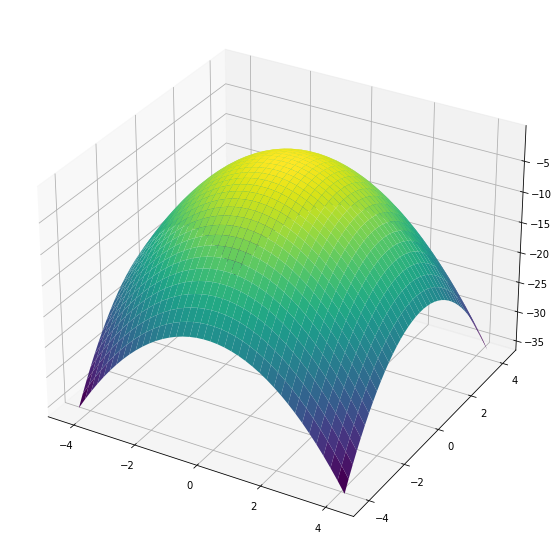

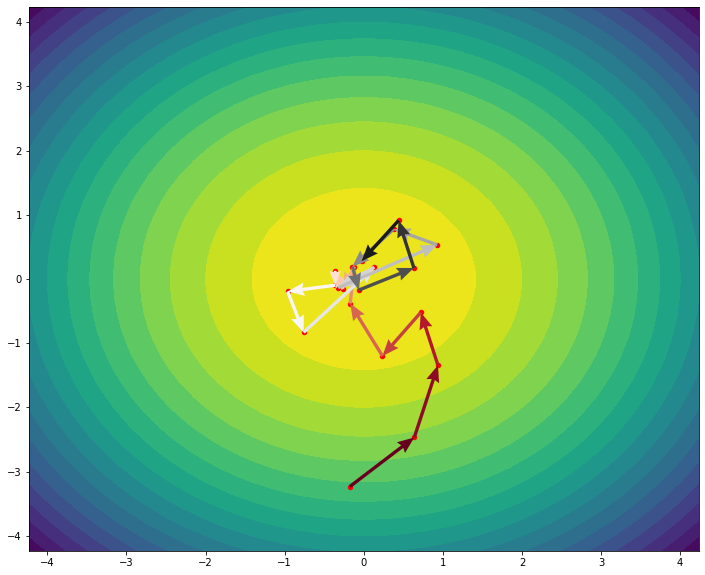

In [81]:
if n == 1:
    edge = min(min(min(s), init_state), -max(max(s), init_state))
    xs = np.linspace(edge - 1, -edge + 1, 100).reshape(100, 1)
    ys = [log_prob(i) for i in xs]

    plt.figure(figsize=(12, 10))
    path = np.asarray([[init_state.numpy()[0], log_prob(init_state)]] + [[i.numpy()[0], log_prob(i)] for i in s]).T
    plt.plot(xs, ys, color='black')
    plt.scatter(path[0], path[1], color='red', s=20)
    plt.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], [i for i in range(opt_len)], \
               scale_units='xy', angles='xy', scale=1, color='k', headwidth=3.0, width=0.005)

    plt.show()
elif n == 2:
    edge = min(min(np.min(s), np.min(init_state)), -max(np.max(s), np.max(init_state)))
    xs = np.linspace(edge - 1, -edge + 1, 40)
    ys = np.linspace(edge - 1, -edge + 1, 40)

    X, Y = np.meshgrid(xs, ys)
    Z = np.asarray([plot_lp(np.stack(xy, axis=1)) for xy in zip(X, Y)])

    path = np.asarray([[init_state.numpy()[0], init_state.numpy()[1], log_prob(init_state)]] + \
                      [[i.numpy()[0], i.numpy()[1], log_prob(i)] for i in s]).T
    
    fig = plt.figure(figsize=(12, 10))
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    #path = np.asarray([[init_state.numpy()[0], log_prob(init_state)]] + [[i.numpy()[0], log_prob(i)] for i in s]).T
    #ax.scatter(path[0], path[1], path[2], color='red', s=50)
    #plt.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], [i for i in range(opt_len)], \
    #           scale_units='xy', angles='xy', scale=1, color='k', headwidth=2.0, width=0.005)

    plt.show()
    
    fig = plt.figure(figsize=(12, 10))
    path = np.asarray([init_state.numpy().tolist()] + s.numpy().tolist()).T
    plt.contourf(X, Y, Z, 20, cmap='viridis')
    plt.scatter(path[0], path[1], color='red', s=20)
    plt.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], [i for i in range(opt_len)], \
               scale_units='xy', angles='xy', scale=1, cmap='RdGy', headwidth=4.0, width=0.005)
    plt.show()

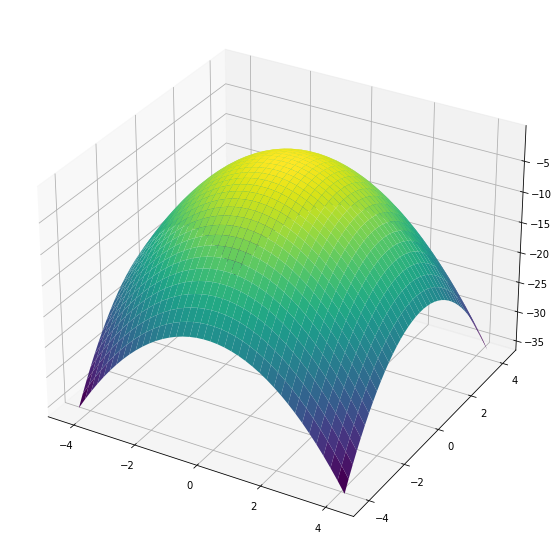

[[-0.17642879  0.62665701  0.62665701  0.62665701  0.62665701  0.62665701
   0.62665701  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.62665701  0.62665701
   0.62665701  0.62665701  0.62665701]
 [-3.23244762  1.87997103  1.87997103  1.87997103  1.87997103  1.87997103
   1.87997103  1.25331402  1.25331402  1.25331402  1.25331402  1.25331402
   1.25331402  1.25331402  1.25331402  1.25331402  0.62665701  0.62665701
   0.62665701  0.62665701  0.62665701]]


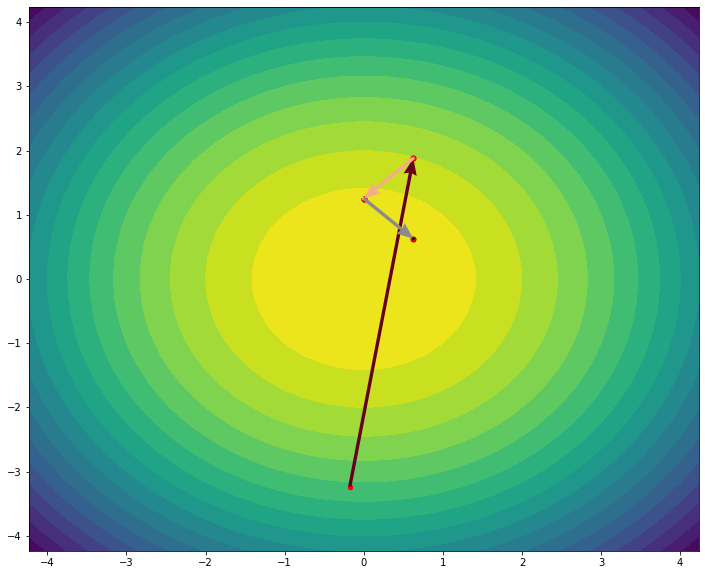

In [82]:
if n == 1:
    edge = min(min(min(s), init_state), -max(max(s), init_state))
    xs = np.linspace(edge - 1, -edge + 1, 100).reshape(100, 1)
    ys = [log_prob(i) for i in xs]
    
    plt.figure(figsize=(12, 10))
    path = np.asarray([[init_state.numpy()[0], log_prob(init_state)]] + [[i.numpy()[0], log_prob(i)] for i in s_q]).T
    plt.plot(xs, ys, color='black')
    plt.scatter(path[0], path[1], color='red', s=20)
    plt.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], [i for i in range(opt_len)], \
               scale_units='xy', angles='xy', scale=1, color='k', headwidth=2.0, width=0.005)

    plt.show()
elif n == 2:
    edge = min(min(np.min(s_q), np.min(init_state)), -max(np.max(s_q), np.max(init_state)))
    xs = np.linspace(edge - 1, -edge + 1, 40)
    ys = np.linspace(edge - 1, -edge + 1, 40)

    X, Y = np.meshgrid(xs, ys)
    Z = np.asarray([plot_lp(np.stack(xy, axis=1)) for xy in zip(X, Y)])

    path = np.asarray([[init_state.numpy()[0], init_state.numpy()[1], log_prob(init_state)]] + \
                      [[i.numpy()[0], i.numpy()[1], log_prob(i)] for i in s]).T
    
    fig = plt.figure(figsize=(12, 10))
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    #path = np.asarray([[init_state.numpy()[0], log_prob(init_state)]] + [[i.numpy()[0], log_prob(i)] for i in s]).T
    #ax.scatter(path[0], path[1], path[2], color='red', s=50)
    #plt.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], [i for i in range(opt_len)], \
    #           scale_units='xy', angles='xy', scale=1, color='k', headwidth=2.0, width=0.005)

    plt.show()
    
    fig = plt.figure(figsize=(12, 10))
    path = np.asarray([init_state.numpy().tolist()] + s_q.numpy().tolist()).T
    print(path)
    plt.contourf(X, Y, Z, 20, cmap='viridis')
    plt.scatter(path[0], path[1], color='red', s=20)
    plt.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], [i for i in range(opt_len)], \
               scale_units='xy', angles='xy', scale=1, cmap='RdGy', headwidth=4.0, width=0.005)
    plt.show()